In [1]:
import os
import sys
import toml

from ipywidgets import interactive, IntSlider
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import polars as pl
import sqlite3
import torch

if '../' not in sys.path:
    sys.path.append('../')

In [2]:
from axe.lsm.cost import Cost
from axe.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from axe.lcm.data.schema import LCMDataSchema, kWORKLOAD_HEADER, kSYSTEM_HEADER
from axe.ltuner.data.schema import LTunerDataSchema
from experiments.evaluate_ltuner import LTunerEvaluator

In [3]:
SYS_COL = kSYSTEM_HEADER
WL_COL = kWORKLOAD_HEADER

Settings to force LaTeX style font within matplotlib plots

In [4]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [5]:
connection = sqlite3.connect("../data/axe_vldb_paper_data.db")
env_table = pl.read_database("SELECT * FROM environments;", connection)
mlos_table = pl.read_database("SELECT * FROM mlos_tunings;", connection)
monkey_table = pl.read_database("SELECT * FROM monkey_evaluation;", connection)

If we want to load in a model and perform the experiment, we can do it with the evaluator

In [6]:
model_path = "../data/ltuner/models/kaplsm_250514_1230/"
config = toml.load(os.path.join(model_path, "axe.toml"))
policy = getattr(Policy, config['lsm']['policy'])
bounds = LSMBounds(**config['lsm']['bounds'])
ltune_schema = LTunerDataSchema(policy=policy, bounds=bounds)
lcm_schema = LCMDataSchema(policy=policy, bounds=bounds)
cost_fn = Cost(bounds.max_considered_levels)

# "Redoing" the experiment
# evaluator = LTunerEvaluator(config, model_path=model_path, model_name="checkpoints/epoch01.model")
# evaluator = LTunerEvaluator(config, model_path=model_path, model_name="best_model.model")
# input_table = pl.read_database("SELECT * FROM environments;", connection)
# ltune_rep_table = evaluator.evaluate(input_table)

# Assuming its in the DB we can
ltune_rep_table = pl.read_database("SELECT * FROM ltune_eval_rep;", connection)

In [7]:
def row_to_objs(row: dict):
    workload = Workload(
        row["empty_reads"],
        row["non_empty_reads"],
        row["range_queries"],
        row["writes"],
    )
    system = System(
        entries_per_page=row["entries_per_page"],
        selectivity=row["selectivity"],
        entry_size=row["entry_size"],
        mem_budget=row["mem_budget"],
        num_entries=row["num_entries"],
    )
    return workload, system   

In [8]:
def load_camal_table(path):
    camal_table= pl.read_csv(path)
    camal_data = camal_table.filter(pl.col('optimizer') == "lr").head(15).to_dicts()
    camal_designs = [
        LSMDesign(
            bits_per_elem=row["h"],
            size_ratio=row["T"],
            policy=(Policy.Leveling if row["is_leveling_policy"] else Policy.Tiering),
            kapacity=()
        )
        for row in camal_data
    ]
    camal_perf_table = []
    for env, design in zip(env_table.to_dicts(), camal_designs):
        workload, system = row_to_objs(env)
        row = LTunerDataSchema.design_to_dict(design)
        row["cost"] = cost_fn.calc_cost(design, system, workload)
        camal_perf_table.append(row)
    camal_perf_table = pl.concat((env_table, pl.DataFrame(camal_perf_table)), how='horizontal')

    return camal_perf_table

In [9]:
camal_perf_table = load_camal_table('../data/camal_optimizer_uniform.csv')
camal_perf_table

env_id,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_entries,mem_budget,read_write_asym,bits_per_elem,size_ratio,policy,cost
i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,str,f64
1,0.25,0.25,0.25,0.25,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",29.697218
2,0.97,0.01,0.01,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",3.343236
3,0.01,0.97,0.01,0.01,8192,0.0000004,4,1000000000,10.0,1.0,6.0,83,"""Policy.Tiering""",5.792324
4,0.01,0.01,0.97,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",106.657372
5,0.01,0.01,0.01,0.97,8192,0.0000004,4,1000000000,10.0,1.0,8.0,94,"""Policy.Leveling""",42.762357
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11,0.01,0.01,0.49,0.49,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",56.290001
12,0.33,0.33,0.33,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",37.622081
13,0.33,0.33,0.01,0.33,8192,0.0000004,4,1000000000,10.0,1.0,5.4,2,"""Policy.Leveling""",3.351225


In [10]:
def get_tuning_costs(env_id):
    ltuner_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)["cost"][0]
    solver_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)["cost_solver"][0]
    camal_cost = camal_perf_table.filter(pl.col('env_id') == env_id)["cost"][0]
    monkey_cost = monkey_table.filter(pl.col('env_id') == env_id)["cost"][0]
    return (solver_cost, ltuner_cost, camal_cost, monkey_cost)

In [108]:
def get_data(env_id):
    env = env_table.filter(pl.col('env_id') == env_id)
    wl = Workload(*env.select(WL_COL).rows()[0])
    system = System(*env.select(SYS_COL).rows()[0])
    ltuner_cost, solver_cost, camal_cost, monkey_cost = get_tuning_costs(env_id)
    
    group = mlos_table.filter(pl.col('env_id') == env_id).group_by('round').agg(
        pl.col('cost').mean().alias('mean'),
        pl.col('cost').std().alias('std'),
        pl.col('cost').count().alias('count')
    )
    group = group.with_columns(ci=(1.96 * pl.col('std') / pl.col('count').sqrt()))
    group = group.with_columns(
        ci_lower=(pl.col('mean') - pl.col('ci')),
        ci_upper=(pl.col('mean') + pl.col('ci')),
        ltuner_cost=ltuner_cost,
        solver_cost=solver_cost,
        camal_cost=camal_cost,
        monkey_cost=monkey_cost
    ).sort(by='round')

    return group, wl, system

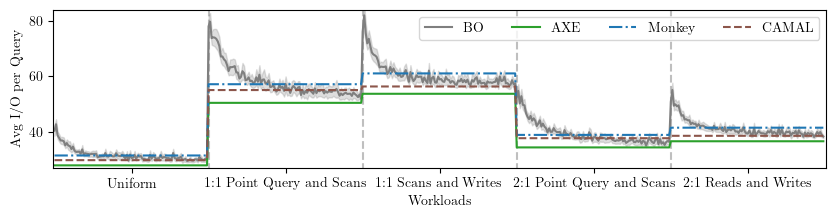

In [157]:
wl_ids = [1, 7, 11, 12, 15]
groups = [group for group, _, _ in (get_data(i) for i in wl_ids)]
wls = [workload for _, workload, _ in (get_data(i) for i in wl_ids)]

table = pl.concat(groups).with_row_index()
min_val = table.select(pl.col(("^.*_cost$", "mean"))).min().min_horizontal()[0]
max_val = table.select(pl.col(("^.*_cost$", "mean"))).max().max_horizontal()[0]

fig, ax = plt.subplots(figsize=(3*width, height))
ax.plot(table['index'], table['mean'], label='BO', color='tab:gray', linestyle='-')
ax.fill_between(table['index'], table['ci_lower'], table['ci_upper'], color='tab:gray', alpha=.25)
ax.plot(table['index'], table['ltuner_cost'], label='AXE', color='tab:green', linestyle='-')
ax.plot(table['index'], table['monkey_cost'], label='Monkey', color='tab:blue', linestyle='-.')
ax.plot(table['index'], table['camal_cost'], label='CAMAL', color='tab:brown', linestyle='--')
ax.legend(ncols=4)
ax.set_ylabel('Avg I/O per Query')
ax.set_xlabel('Workloads')
ax.vlines(x=100, ymin=min_val-10, ymax=max_val+10, linestyle='--', color='black', alpha=0.25, zorder=-1)
ax.vlines(x=200, ymin=min_val-10, ymax=max_val+10, linestyle='--', color='black', alpha=0.25, zorder=-1)
ax.vlines(x=300, ymin=min_val-10, ymax=max_val+10, linestyle='--', color='black', alpha=0.25, zorder=-1)
ax.vlines(x=400, ymin=min_val-10, ymax=max_val+10, linestyle='--', color='black', alpha=0.25, zorder=-1)
ax.set_ylim([min_val-1, max_val+2])
ax.set_xticks([50, 150, 250, 350, 450])
ax.set_xlim([-1, 501])
ax.set_xticklabels(["Uniform", "1:1 Point Query and Scans", "1:1 Scans and Writes", "2:1 Point Query and Scans", "2:1 Reads and Writes"])
# ax.set_title(f'Workload: $w_{{{env_id - 1}}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$')
plt.show()

In [158]:
save_fig(fig, "changing_workloads.pdf")